<a href="https://colab.research.google.com/github/SachinLamichhane/Tuberculosis-detection/blob/main/GRADCAMandLIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

data_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database'




 **Create directories for training and validation data**

In [4]:
train_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_train'
validation_dir = '/content/drive/MyDrive/TB_Chest_Radiography_Database_validation'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

##  Create class subdirectories in training and validation directories

In [5]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Create class subdirectories in training and validation directories
class_names = ['Tuberculosis', 'Normal']  # Adjust class names accordingly
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

In [6]:
class_names = ['Tuberculosis', 'Normal']
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)


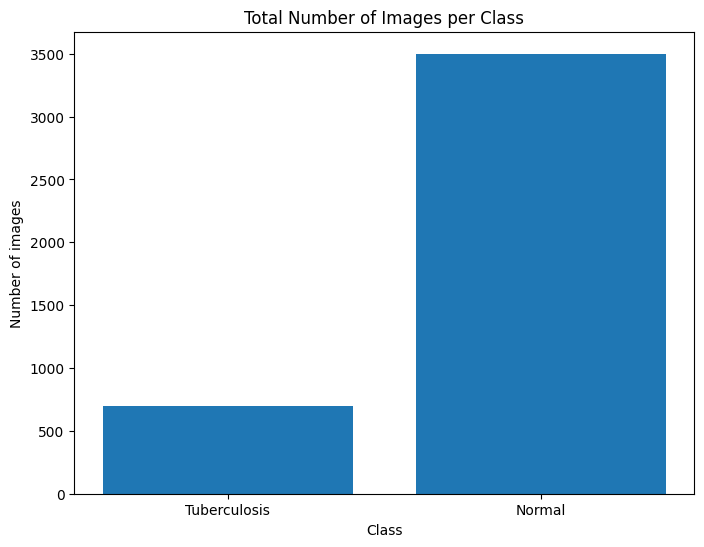

In [7]:
# Convert labels to numeric format
label_dict = {class_name: idx for idx, class_name in enumerate(class_names)}
labels = np.array([label_dict[label] for label in labels])

# Plot total number of images per class
def plot_distribution(data, title):
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, [np.sum(data == label_dict[class_name]) for class_name in class_names])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()

# Plot initial distribution of images
plot_distribution(labels, 'Total Number of Images per Class')

## Split data into training and validation sets

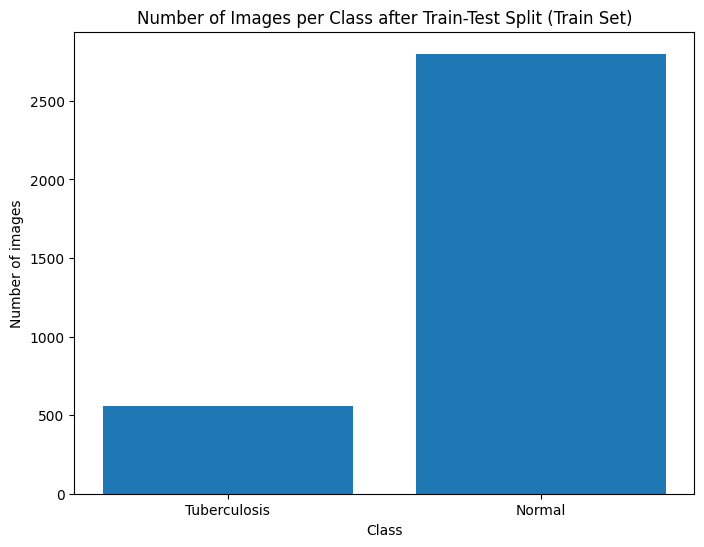

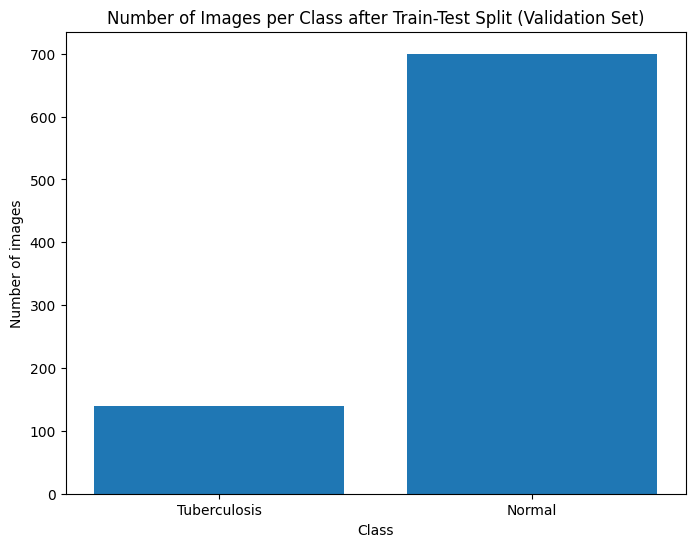

In [8]:
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Plot distribution of images after train-test split
plot_distribution(train_labels, 'Number of Images per Class after Train-Test Split (Train Set)')
plot_distribution(val_labels, 'Number of Images per Class after Train-Test Split (Validation Set)')


# Apply random undersampling to balance the classes in the training set

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


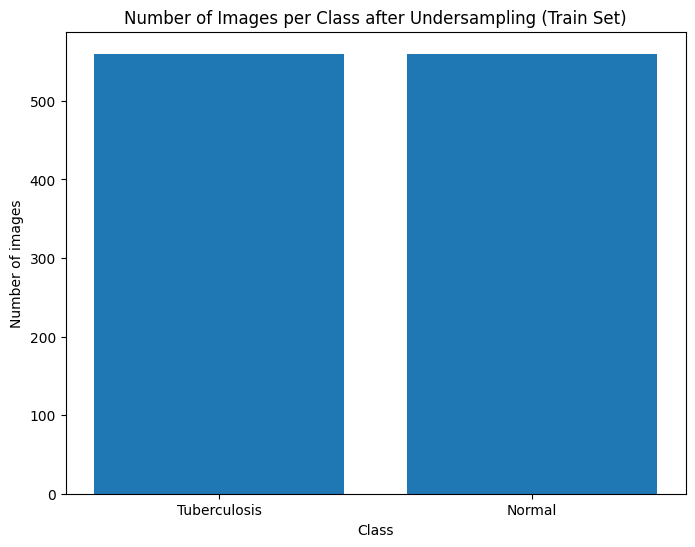

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


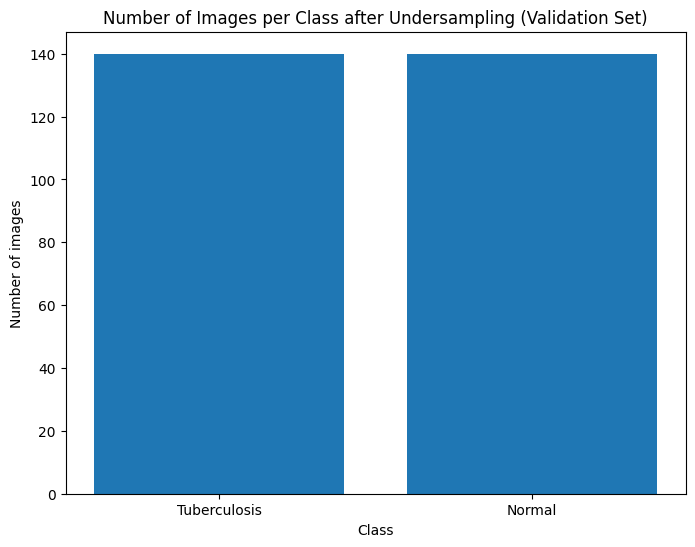

In [9]:
# Plot distribution of images after undersampling
rus = RandomUnderSampler()
train_paths, train_labels = rus.fit_resample(np.array(train_paths).reshape(-1, 1), train_labels)
train_paths = train_paths.flatten()
plot_distribution(train_labels, 'Number of Images per Class after Undersampling (Train Set)')
# Apply random undersampling to balance the classes in the validation set
val_paths, val_labels = rus.fit_resample(np.array(val_paths).reshape(-1, 1), val_labels)
val_paths = val_paths.flatten()
plot_distribution(val_labels, 'Number of Images per Class after Undersampling (Validation Set)')




In [10]:
# Copy images to respective directories and count them
def copy_images(image_paths, labels, target_dir):
    count = {class_name: 0 for class_name in class_names}
    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        target_class_dir = os.path.join(target_dir, class_name)
        shutil.copy(img_path, target_class_dir)
        count[class_name] += 1
    return count

train_count = copy_images(train_paths, train_labels, train_dir)
val_count = copy_images(val_paths, val_labels, validation_dir)

print("Number of images copied for training after undersampling:")
print(train_count)

print("Number of images copied for validation after undersampling:")
print(val_count)





Number of images copied for training after undersampling:
{'Tuberculosis': 560, 'Normal': 560}
Number of images copied for validation after undersampling:
{'Tuberculosis': 140, 'Normal': 140}


## transfer learning with dense121

In [60]:
base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(224, 224, 3))

# Add custom layers on top of the base model for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (1 output unit with sigmoid activation)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [61]:
# Prepare data generators for training and validation datasets
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize pixel values to [0, 1]
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values to [0, 1]

train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directory containing the training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = True)  # Binary classification

validation_generator = test_datagen.flow_from_directory(
    validation_dir,  # Directory containing the validation data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle = False)  # Binary classification

Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


## training

In [63]:
 model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Reduce steps per epoch
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Reduce validation steps
    epochs=1,  # Keep it low

)


35/35 ━━━━━━━━━━━━━━━━━━━━ 317s 9s/step - accuracy: 0.9381 - loss: 0.1864 - val_accuracy: 0.9727 - val_loss: 0.0903


In [65]:
model.save("/content/drive/MyDrive/Models/CNNmetrics.h5")


## Evaluating the model

9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       140
Tuberculosis       0.98      0.96      0.97       140

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280



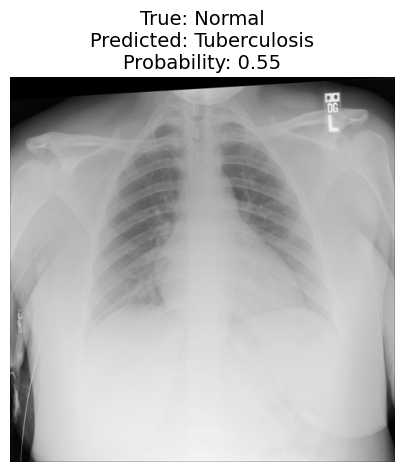

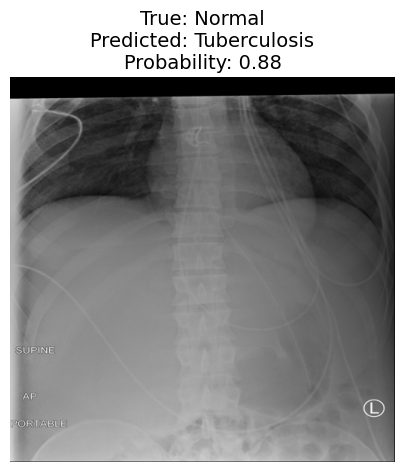

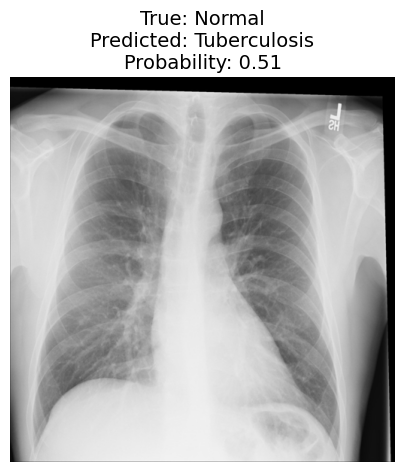

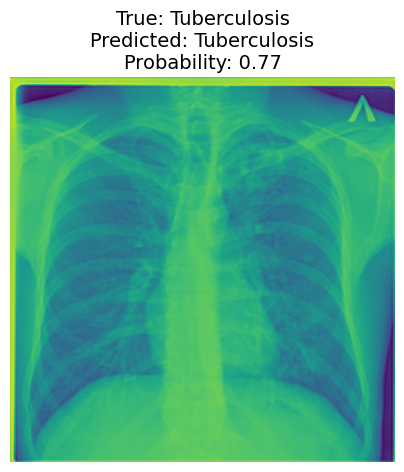

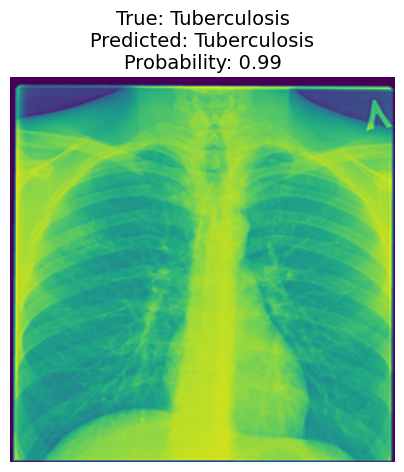

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Define the label names corresponding to the model's output classes
LABELS = ["Normal", "Tuberculosis"]

# Predict the classes for the validation set
val_preds = model.predict(validation_generator)
val_preds_class = (val_preds > 0.5).astype(int)  # Convert probabilities to binary classes

# Get the true labels and image file paths
val_true_labels = validation_generator.classes
val_image_paths = validation_generator.filepaths  # File paths for validation images

# Print classification report
print(classification_report(val_true_labels, val_preds_class, target_names=LABELS))

# Display only images classified as Tuberculosis
def display_tuberculosis_predictions(num_images=5):
    count = 0  # Counter for images displayed

    for i in range(len(val_preds_class)):
        if val_preds_class[i][0] == 1:  # Check if classified as Tuberculosis
            img_path = val_image_paths[i]
            true_label = LABELS[val_true_labels[i]]
            predicted_label = LABELS[val_preds_class[i][0]]
            prediction_value = val_preds[i][0]

            # Load and preprocess the image for display
            img = plt.imread(img_path)

            # Plot the image with true and predicted labels, and prediction value
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('Off')
            plt.title(f"True: {true_label}\nPredicted: {predicted_label}\nProbability: {prediction_value:.2f}", fontsize=14)
            plt.show()

            count += 1
            if count == num_images:  # Stop after displaying the specified number of images
                break

# Show predictions for images classified as Tuberculosis
display_tuberculosis_predictions(num_images=5)





In [67]:
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
true_classes = validation_generator.classes
print("Classification Report:")
print(classification_report(true_classes, val_preds_class))
true_classes = true_classes[:len(val_preds_class)]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       140
           1       0.98      0.96      0.97       140

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280



## Accuracy plotting

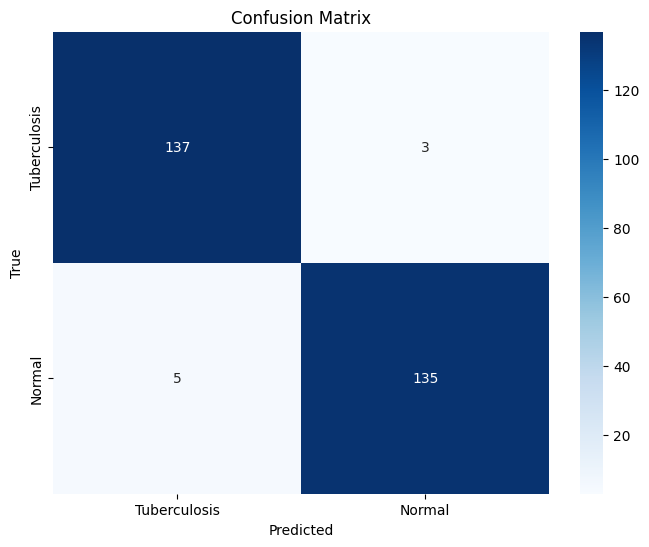

In [68]:
import seaborn as sns
# Compute the classification report
val_labels_true = validation_generator.classes
# Plot confusion matrix
conf_matrix = confusion_matrix(val_labels_true, val_preds_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step


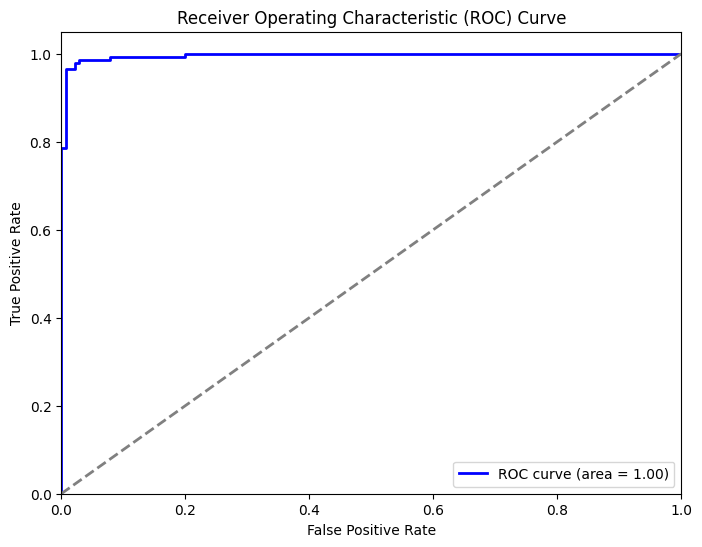

In [69]:
# Plot AUC-ROC curve
val_preds_prob = model.predict(validation_generator)
fpr, tpr, _ = roc_curve(val_labels_true, val_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


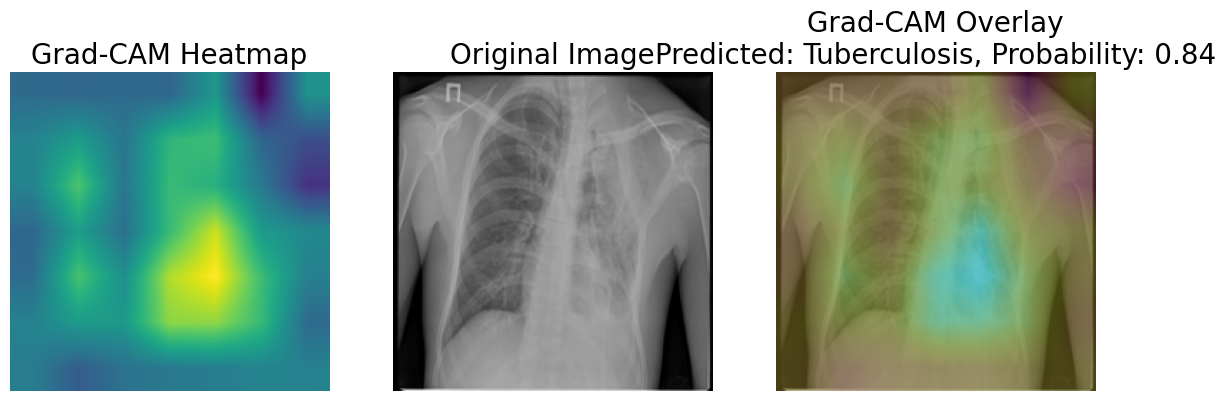

In [70]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # If no layer is specified, attempt to find the last 4D layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Loop over layers in reverse order to find the last convolutional layer
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find a 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Create a gradient model to extract activations and predictions
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output],
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, tf.argmax(predictions[0])]

        # Compute gradients of the loss with respect to the convolutional outputs
        grads = tape.gradient(loss, convOutputs)

        # Guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # Average weights of the gradients
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs[0]), axis=-1)

        # Resize heatmap to match input image size
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # Apply color map and overlay heatmap on the original image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)


# Function to process a single image
def process_single_image(img_path, model, target_layer):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image at path: {img_path}")

    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    original_img = cv2.resize(original_img, (224, 224))  # Resize to match heatmap dimensions
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict the class and probability
    preds = model.predict(img_array)
    predicted_prob = preds[0][0]  # For binary classification, this gives the probability of the positive class (e.g., Tuberculosis)

    # Default threshold (can be customized)
    threshold = 0.5

    # Determine predicted class based on the probability
    predicted_label = "Tuberculosis" if predicted_prob >= threshold else "Normal"

    # Compute Grad-CAM
    cam = GradCAM(model, classIdx=0, layerName=target_layer)
    heatmap = cam.compute_heatmap(img_array)

    # Overlay heatmap on the original image
    heatmap_resized, overlay = cam.overlay_heatmap(heatmap, original_img)

    # Plot results
    fig, ax = plt.subplots(1, 3, figsize=(14, 14))
    ax[0].imshow(heatmap, cmap="viridis")
    ax[0].axis("Off")
    ax[0].set_title("Grad-CAM Heatmap", fontsize=20)

    ax[1].imshow(original_img)
    ax[1].axis("Off")
    ax[1].set_title("Original Image", fontsize=20)

    ax[2].imshow(overlay)
    ax[2].axis("Off")
    ax[2].set_title(f"Grad-CAM Overlay\nPredicted: {predicted_label}, Probability: {predicted_prob:.2f}", fontsize=20)

    plt.show()

# Specify the target convolutional layer and image path
target_layer = "conv5_block16_1_conv"  # Replace with the appropriate layer for your model
img_path = "/content/drive/MyDrive/TB_Chest_Radiography_Database_train/Tuberculosis/Tuberculosis-109.png"  # Replace with the full path to your image

# Process and display Grad-CAM for the image
process_single_image(img_path, model, target_layer)

In [30]:
pip install beexai

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.7 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=22de917381e132b3ad3ba6def8e12c1afa3174f885d7ef7ddc74ce0a593301b5
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [71]:
def calculate_faithfulness(model, heatmap, img_array, target_class, top_k=10):
    # Get the original prediction
    original_pred = model.predict(img_array)[0][target_class]

    # Identify top-k regions in the heatmap
    mask = np.zeros_like(heatmap)
    flattened_indices = np.argsort(heatmap.flatten())[::-1][:top_k]
    np.put(mask, flattened_indices, 1)
    mask = mask.reshape(heatmap.shape)

    # Expand mask to match the dimensions of img_array
    mask = np.expand_dims(mask, axis=(0, -1))  # Add batch and channel dimensions

    # Suppress the top-k important regions
    masked_img_array = img_array * (1 - mask)

    # Get the new prediction after perturbation
    new_pred = model.predict(masked_img_array)[0][target_class]

    # Faithfulness is the drop in confidence
    faithfulness_score = original_pred - new_pred
    return faithfulness_score

In [72]:
from sklearn.metrics import jaccard_score

def calculate_localization_accuracy(heatmap, ground_truth_mask, threshold=0.5):
    # Binarize the heatmap and ground truth mask
    binary_heatmap = (heatmap >= threshold).astype(int)
    binary_ground_truth = (ground_truth_mask >= threshold).astype(int)

    # Compute Intersection over Union (IoU)
    iou_score = jaccard_score(binary_ground_truth.flatten(), binary_heatmap.flatten())
    return iou_score

In [73]:
def calculate_compactness(heatmap, threshold=0.5):
    # Count the number of important pixels (above the threshold)
    num_important_pixels = np.sum(heatmap >= threshold)
    total_pixels = heatmap.size

    # Compactness is the ratio of important pixels to total pixels
    compactness_score = num_important_pixels / total_pixels
    return compactness_score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Faithfulness Score: 0.1923
Localization Accuracy (IoU): 0.5026
Compactness Score: 0.9994


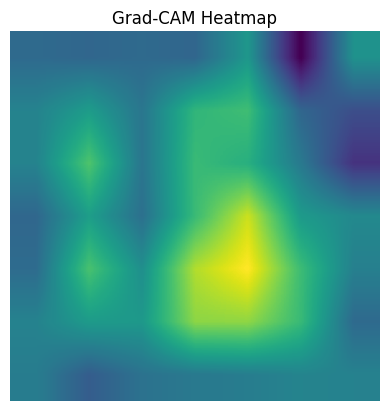

In [75]:
def process_image_and_calculate_metrics(img_path, model, target_layer, target_class, ground_truth_mask=None):
    # Load and preprocess the image
    img = cv2.imread(img_path)
    original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img_array = np.expand_dims(img, axis=0)

    # Compute Grad-CAM
    cam = GradCAM(model, classIdx=target_class, layerName=target_layer)
    heatmap = cam.compute_heatmap(img_array)

    # Calculate Faithfulness
    faithfulness_score = calculate_faithfulness(model, heatmap, img_array, target_class)
    print(f"Faithfulness Score: {faithfulness_score:.4f}")

    # Calculate Localization Accuracy
    if ground_truth_mask is not None:
        localization_accuracy = calculate_localization_accuracy(heatmap, ground_truth_mask)
        print(f"Localization Accuracy (IoU): {localization_accuracy:.4f}")
    else:
        print("Ground truth mask not provided. Skipping Localization Accuracy.")

    # Calculate Compactness
    compactness_score = calculate_compactness(heatmap)
    print(f"Compactness Score: {compactness_score:.4f}")


    # Visualization (optional)
    plt.imshow(heatmap, cmap="viridis")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

# Example Usage
img_path = "/content/drive/MyDrive/TB_Chest_Radiography_Database_train/Tuberculosis/Tuberculosis-109.png"
target_layer = "conv5_block16_1_conv"
target_class = 0
ground_truth_mask = np.random.randint(0, 2, (224, 224))  # Replace with actual ground truth mask

process_image_and_calculate_metrics(img_path, model, target_layer, target_class, ground_truth_mask)

In [76]:
def calculate_robustness_mse(model, gradcam, img_array, target_class, num_perturbations=5, noise_std=0.01):
    original_heatmap = gradcam.compute_heatmap(img_array)
    mse_scores = []

    for _ in range(num_perturbations):
        noise = np.random.normal(0, noise_std, img_array.shape)
        perturbed_img = np.clip(img_array + noise, 0, 1)

        perturbed_heatmap = gradcam.compute_heatmap(perturbed_img)
        mse_score = np.mean((original_heatmap - perturbed_heatmap) ** 2)
        mse_scores.append(mse_score)

    return np.mean(mse_scores)

In [78]:

target_layer = "conv5_block16_1_conv"  # Replace with your model's target layer
img_path = "/content/drive/MyDrive/TB_Chest_Radiography_Database_train/Tuberculosis/Tuberculosis-109.png"  # Replace with your image path

# Instantiate GradCAM
gradcam = GradCAM(model, classIdx=0, layerName=target_layer)

# Process the image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224)) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img, axis=0)  # Add batch dimension

# Calculate robustness
robustness_score_mse = calculate_robustness_mse(model, gradcam, img_array, target_class=0)
print(f"Robustness Score (MSE): {robustness_score_mse/100:.2f}")

Robustness Score (MSE): 0.85


**LIME Explanation**

In [80]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bda2561c13216185b8604d0f4b168dbcadc88a6135c6c10bd1d11797b0611976
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [96]:
import lime
from lime.lime_image import LimeImageExplainer
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Initialize LIME Explainer
explainer = LimeImageExplainer()

# File path to the image
image_path = "/content/drive/MyDrive/TB_Chest_Radiography_Database_train/Tuberculosis/Tuberculosis-109.png"

# Load and preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):  # Adjust size if required by your model
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image) / 255.0  # Normalize the image
    return image, np.expand_dims(image_array, axis=0)

# Preprocess the image
original_image, processed_image = preprocess_image(image_path)

# Predict the class for the image
predicted_probs = model.predict(processed_image)
predicted_class = 1 if predicted_probs[0][0] > 0.5 else 0  # Threshold at 0.5

# Print the predicted class and probabilities
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probabilities: {predicted_probs}")

# Explain the prediction using LIME
explanation = explainer.explain_instance(
    image=processed_image[0],
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,  # Only consider the top label
    hide_color=0,
    num_samples=5000
)

# Get explanation for the top predicted label
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
Predicted Class: 1
Prediction Probabilities: [[0.8563118]]


  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

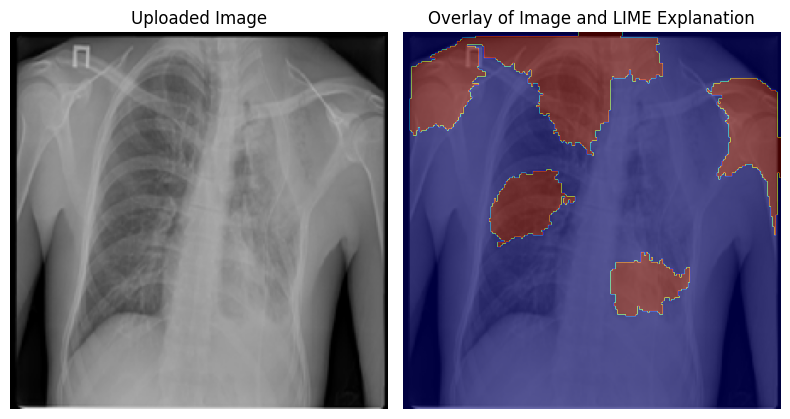

In [97]:
import numpy as np

# Convert the PIL image (original_image) to a NumPy array for display
original_image_array = np.array(original_image)

plt.figure(figsize=(8,8))

# Display the original uploaded image
plt.subplot(1, 2, 1)
plt.imshow(original_image_array.astype("uint8"))
plt.title("Uploaded Image")
plt.axis('off')



# Display the overlay of the original image and LIME explanation
plt.subplot(1, 2, 2)
plt.imshow(original_image_array.astype("uint8") / 255.0)  # Normalize the original image for combining
plt.imshow(mask, cmap="jet", alpha=0.5)  # Overlay LIME explanation with transparency
plt.title("Overlay of Image and LIME Explanation")
plt.axis('off')

plt.tight_layout()
plt.show()

**Metrics for LIME**

In [100]:
def calculate_faithfulness(explanation, model, processed_image):
    label = explanation.top_labels[0]
    weights = explanation.local_exp[label]
    sorted_features = sorted(weights, key=lambda x: x[1], reverse=True)

    original_pred = model.predict(processed_image)[0][label]

    faithfulness_scores = []
    for feature_idx, _ in sorted_features:
        perturbed_image = processed_image[0].copy()
        perturbed_image[explanation.segments == feature_idx] = 0  # Set the region to black (baseline)
        perturbed_pred = model.predict(np.expand_dims(perturbed_image, axis=0))[0][label]
        faithfulness_scores.append(original_pred - perturbed_pred)

    return np.mean(faithfulness_scores)

faithfulness = calculate_faithfulness(explanation, model, processed_image)
print(f"Faithfulness: {faithfulness}")

def calculate_robustness(explanation, model, processed_image, epsilon=0.01, num_perturbations=10):
    label = explanation.top_labels[0]
    original_weights = explanation.local_exp[label]

    robustness_scores = []
    for _ in range(num_perturbations):
        perturbed_image = processed_image[0] + epsilon * np.random.normal(size=processed_image[0].shape)
        perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure pixel values remain valid
        new_explanation = explainer.explain_instance(
            image=perturbed_image,
            classifier_fn=lambda x: model.predict(x),
            top_labels=1,
            hide_color=0,
            num_samples=500
        )
        new_weights = new_explanation.local_exp[label]
        difference = np.linalg.norm(np.array(original_weights) - np.array(new_weights))
        robustness_scores.append(difference)

    return np.mean(robustness_scores)

def calculate_compactness(explanation):
    label = explanation.top_labels[0]
    num_features = len(explanation.local_exp[label])
    return num_features

compactness = calculate_compactness(explanation)
print(f"Compactness: {compactness/100}")

def calculate_localization_accuracy(explanation, ground_truth_mask):
    label = explanation.top_labels[0]
    _, mask = explanation.get_image_and_mask(
        label=label, positive_only=True, num_features=10, hide_rest=False
    )
    intersection = np.sum(mask * ground_truth_mask)
    union = np.sum((mask + ground_truth_mask) > 0)
    iou = intersection / union if union != 0 else 0
    return iou

# Replace `ground_truth_mask` with the actual mask for the input image
localization_accuracy = calculate_localization_accuracy(explanation, ground_truth_mask)
print(f"Localization Accuracy: {localization_accuracy}")

import time

def calculate_complexity(explainer, model, processed_image):
    start_time = time.time()
    _ = explainer.explain_instance(
        image=processed_image[0],
        classifier_fn=lambda x: model.predict(x),
        top_labels=1,
        hide_color=0,
        num_samples=500
    )
    end_time = time.time()
    return end_time - start_time

complexity = calculate_complexity(explainer, model, processed_image)
print(f"Complexity: {complexity/100} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [103]:
def calculate_robustness(explanation, model, processed_image, epsilon=0.01, num_perturbations=10):
    label = explanation.top_labels[0]
    original_weights = dict(explanation.local_exp[label])  # Convert to dictionary for easier alignment

    robustness_scores = []
    for i in range(num_perturbations):
        try:
            print(f"Perturbation {i + 1}/{num_perturbations}")
            perturbed_image = processed_image[0] + epsilon * np.random.normal(size=processed_image[0].shape)
            perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure pixel values remain valid

            # Generate explanation for perturbed image
            new_explanation = explainer.explain_instance(
                image=perturbed_image,
                classifier_fn=lambda x: model.predict(x),
                top_labels=1,
                hide_color=0,
                num_samples=500
            )

            new_weights = dict(new_explanation.local_exp[label])  # Convert to dictionary

            # Align weights by feature indices
            common_features = set(original_weights.keys()).intersection(new_weights.keys())
            aligned_original_weights = np.array([original_weights[f] for f in common_features])
            aligned_new_weights = np.array([new_weights[f] for f in common_features])

            # Calculate the norm difference
            difference = np.linalg.norm(aligned_original_weights - aligned_new_weights)
            robustness_scores.append(difference)
        except Exception as e:
            print(f"Error during perturbation {i + 1}: {e}")

    if robustness_scores:
        return np.mean(robustness_scores)
    else:
        print("No robustness scores calculated!")
        return None
robustness = calculate_robustness(explanation, model, processed_image)
print(f"Robustness: {robustness}")

Perturbation 1/10


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 